<a href="https://colab.research.google.com/github/AgniKoko/Image_Watermark_with_DCT/blob/main/watermark_dct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.fft import dct, idct,dst, idst
import urllib.request
from google.colab.patches import cv2_imshow

In [2]:
# Function to compute the 2D DCT of an image
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

# Function to compute the 2D inverse DCT of an image
def idct2(image):
    return idct(idct(image.T, norm='ortho').T, norm='ortho')

# Εφαρμογη Watermark

In [4]:
# image = cv2.imread('school_of_athens.png')
# cv2_imshow(image)
image = cv2.imread('school_of_athens.png',cv2.IMREAD_GRAYSCALE)
# cv2_imshow(image)
h, w = image.shape
print(image.shape)

(1200, 1920)


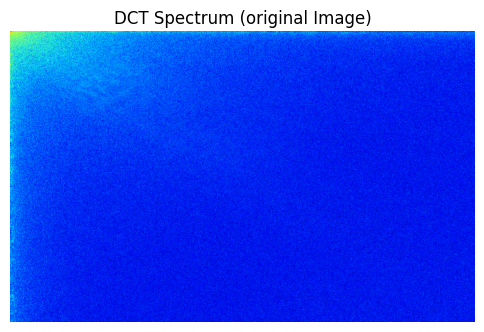

In [5]:
dct_image = dct2(image)

plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(dct_image) + 1), cmap='jet')
plt.title('DCT Spectrum (original Image)')
plt.axis('off')
plt.show()

In [55]:
# watermark = cv2.imread('watermark.png')
# cv2_imshow(watermark)
watermark = cv2.imread('watermark.png',cv2.IMREAD_GRAYSCALE)
# cv2_imshow(watermark)
print(watermark.shape)

(971, 1294)


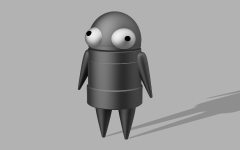

(150, 240)


In [76]:
# Αλλαγή μεγέθους του watermark ώστε να ταιριάζει στον αριθμό των blocks (π.χ., 150 x 240)
# Αν τα blocks είναι 8x8:
blocks_h = h // 8
blocks_w = w // 8
watermark = cv2.resize(watermark, (blocks_w, blocks_h))
cv2_imshow(watermark)
print(watermark.shape)

In [77]:
# Μετατροπή σε δυαδική εικόνα (thresholding)
_, watermark_bin = cv2.threshold(watermark, 128, 1, cv2.THRESH_BINARY)

# Δημιουργία αντίγραφου της εικόνας για το watermarking
final_image = np.zeros_like(image, dtype=np.float32)
# Δημιουργία πίνακα για αποθήκευση των τιμών του επιλεγμένου συντελεστή (π.χ., [3,2])
watermark_map = np.zeros((blocks_h, blocks_w))

block_size = 8

In [78]:
# Παράγοντας κλιμάκωσης
alpha = 5

# Διαδικασία για κάθε μπλοκ
for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = image[i:i+block_size, j:j+block_size].astype(np.float32)
        dct_block = dct2(block)

        # Επιλογή του αντίστοιχου watermark bit για το block
        # Οι συντεταγμένες στο watermark αντίστοιχες με το block grid:
        wm_i = i // block_size
        wm_j = j // block_size
        bit = watermark_bin[wm_i, wm_j]
        # Ορισμός τιμής bit σε +1 ή -1
        b = 1 if bit == 1 else -1

        # Τροποποίηση του επιλεγμένου συντελεστή (π.χ. θέση [3,2])
        dct_block[3, 2] += alpha * b

        # Εφαρμογή της αντίστροφης DCT
        idct_block = idct2(dct_block)
        final_image[i:i+block_size, j:j+block_size] = idct_block

cv2.imwrite('final_image.png', final_image)

True

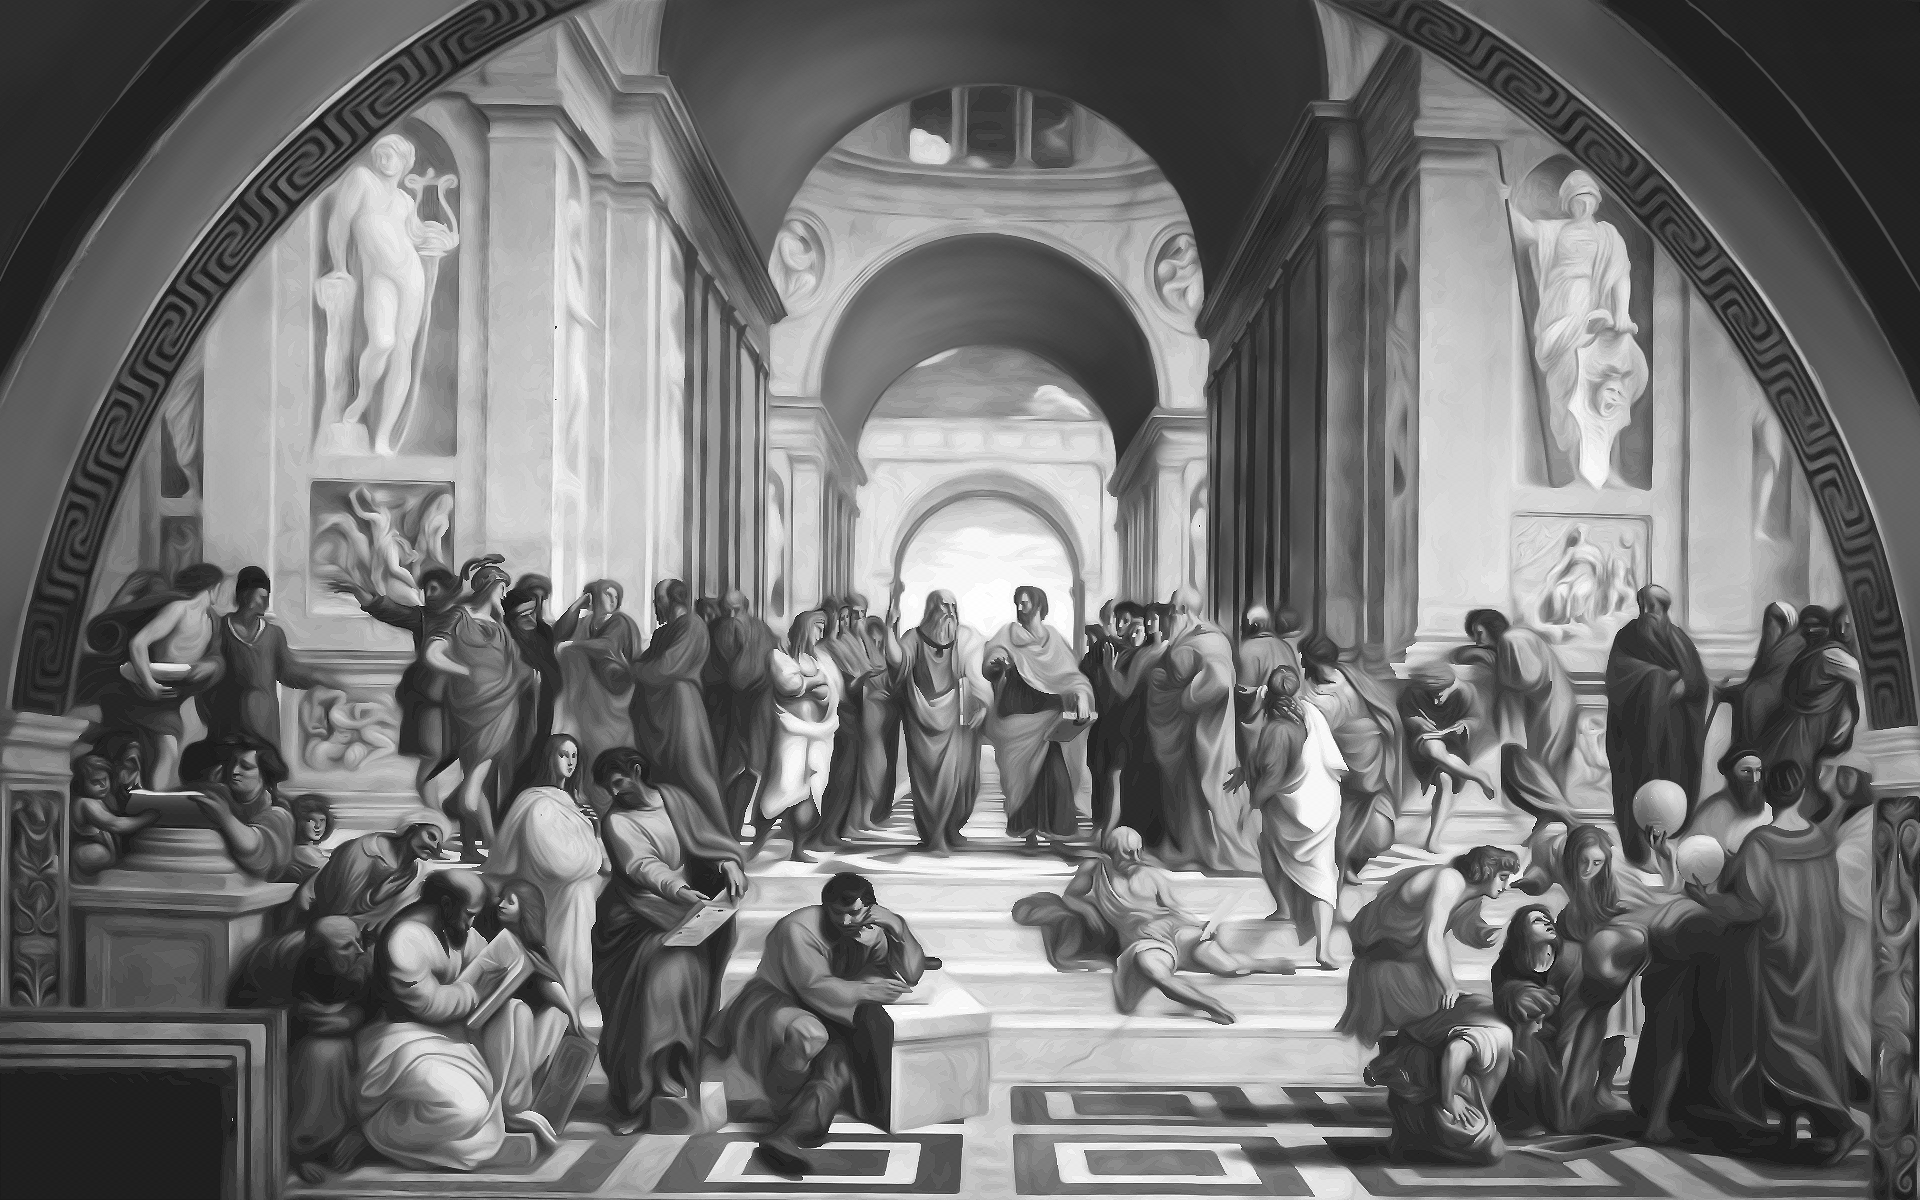

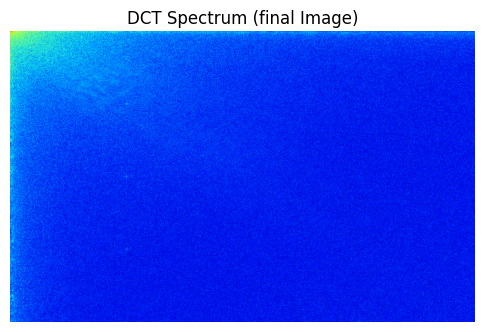

In [79]:
# Μετατροπή της τελικής εικόνας στο εύρος [0,255] και αποθήκευση
final_image = np.clip(final_image, 0, 255).astype(np.uint8)
cv2_imshow(final_image)

dct_image = dct2(final_image)

plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(dct_image) + 1), cmap='jet')
plt.title('DCT Spectrum (final Image)')
plt.axis('off')
plt.show()

In [80]:
# Διέρμηση της εικόνας σε μπλοκ και εξαγωγή του συντελεστή από κάθε μπλοκ
for i in range(blocks_h):
    for j in range(blocks_w):
        # Απόκτηση του τρέχοντος μπλοκ
        block = final_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)

        # Εφαρμογή DCT στο μπλοκ
        dct_block = dct2(block)

        # Εξαγωγή του επιλεγμένου συντελεστή, π.χ. στη θέση [3,2]
        watermark_map[i, j] = dct_block[3, 2]

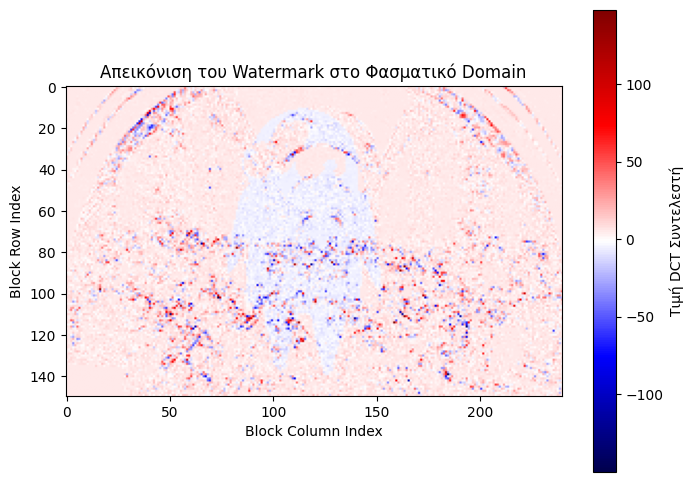

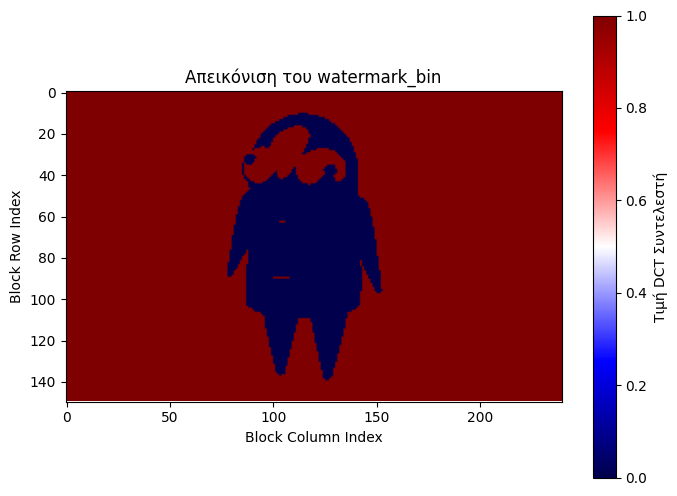

In [81]:
# Οπτικοποίηση του χάρτη των τιμών (το φασματικό αποτύπωμα του watermark)
plt.figure(figsize=(8, 6))
plt.imshow(watermark_map, cmap='seismic')
plt.colorbar(label='Τιμή DCT Συντελεστή')
plt.title('Απεικόνιση του Watermark στο Φασματικό Domain')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(watermark_bin, cmap='seismic')
plt.colorbar(label='Τιμή DCT Συντελεστή')
plt.title('Απεικόνιση του watermark_bin')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')
plt.show()

# Ανακτηση Watermark

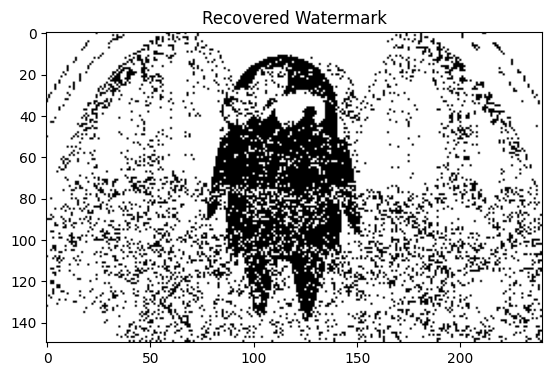

In [89]:
# Φόρτωση της τελικής watermarked εικόνας
watermarked_image = cv2.imread('final_image.png', cv2.IMREAD_GRAYSCALE)
h, w = watermarked_image.shape

# Χάρτης για το ανακτημένο watermark
recovered_watermark = np.zeros((blocks_h, blocks_w))

# Κατώφλι για απόφαση (προσαρμόστε το ανάλογα με τις τιμές)
threshold = 0

for i in range(blocks_h):
    for j in range(blocks_w):
        block = watermarked_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)
        dct_block = dct2(block)
        coeff_value = dct_block[3, 2]  # ο επιλεγμένος συντελεστής
        # Απόφαση: αν ο συντελεστής > threshold θεωρούμε bit 1, αλλιώς bit 0 (ή +1 και -1)
        recovered_watermark[i, j] = 1 if coeff_value > threshold else 0

# Οπτικοποίηση του ανακτημένου watermark
plt.imshow(recovered_watermark, cmap='gray')
plt.title("Recovered Watermark")
plt.show()


# 1. Διαφορά DCT

In [90]:
# Δημιουργούμε πίνακες για την αποθήκευση των επιλεγμένων συντελεστών (π.χ., θέση [3,2])
original_coeff_map = np.zeros((blocks_h, blocks_w))
watermarked_coeff_map = np.zeros((blocks_h, blocks_w))

# Διατρέχουμε τα μπλοκ και υπολογίζουμε τον DCT σε κάθε μπλοκ για κάθε εικόνα
for i in range(blocks_h):
    for j in range(blocks_w):
        # Απόκτηση του μπλοκ στην αρχική εικόνα
        block_orig = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)
        dct_block_orig = dct2(block_orig)
        original_coeff_map[i, j] = dct_block_orig[3, 2]

        # Απόκτηση του αντίστοιχου μπλοκ στη watermarked εικόνα
        block_wm = final_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)
        dct_block_wm = dct2(block_wm)
        watermarked_coeff_map[i, j] = dct_block_wm[3, 2]

# Υπολογισμός της διαφοράς των συντελεστών για κάθε μπλοκ
difference_map = watermarked_coeff_map - original_coeff_map

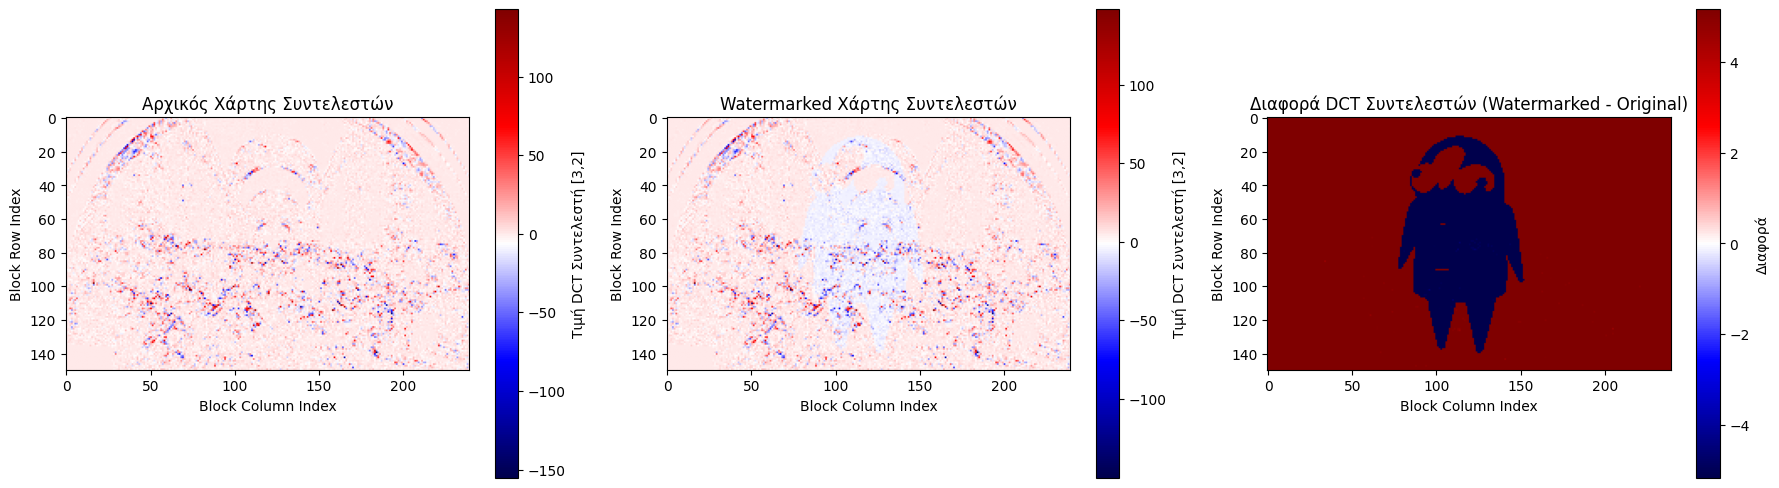

In [91]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_coeff_map, cmap='seismic')
plt.colorbar(label='Τιμή DCT Συντελεστή [3,2]')
plt.title('Αρχικός Χάρτης Συντελεστών')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')

plt.subplot(1, 3, 2)
plt.imshow(watermarked_coeff_map, cmap='seismic')
plt.colorbar(label='Τιμή DCT Συντελεστή [3,2]')
plt.title('Watermarked Χάρτης Συντελεστών')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')

plt.subplot(1, 3, 3)
plt.imshow(difference_map, cmap='seismic')
plt.colorbar(label='Διαφορά')
plt.title('Διαφορά DCT Συντελεστών (Watermarked - Original)')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')

plt.tight_layout()
plt.show()

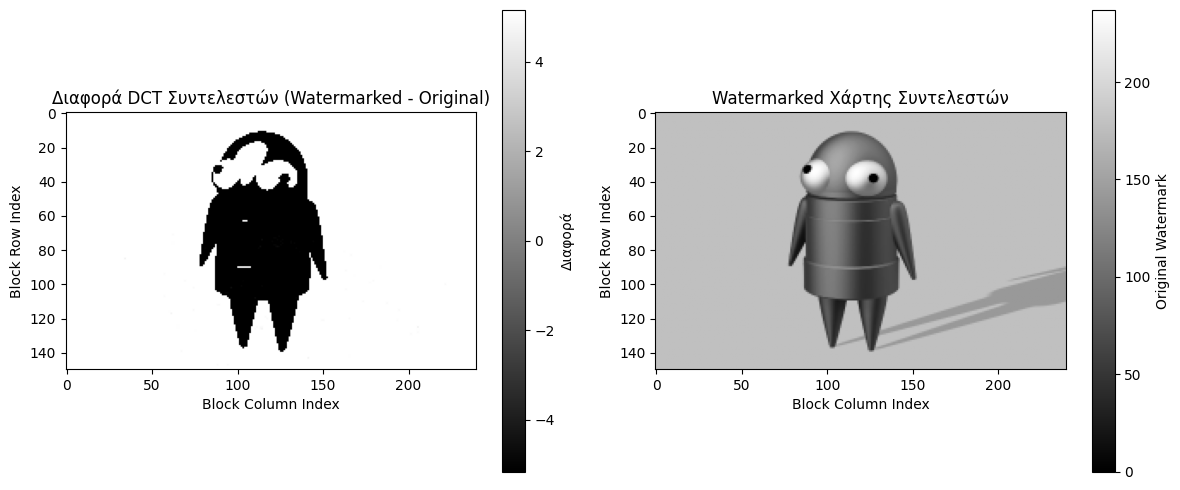

In [92]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(difference_map, cmap='gray')
plt.colorbar(label='Διαφορά')
plt.title('Διαφορά DCT Συντελεστών (Watermarked - Original)')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')

plt.subplot(1, 2, 2)
plt.imshow(watermark, cmap='gray')
plt.colorbar(label='Original Watermark')
plt.title('Watermarked Χάρτης Συντελεστών')
plt.xlabel('Block Column Index')
plt.ylabel('Block Row Index')

plt.tight_layout()
plt.show()

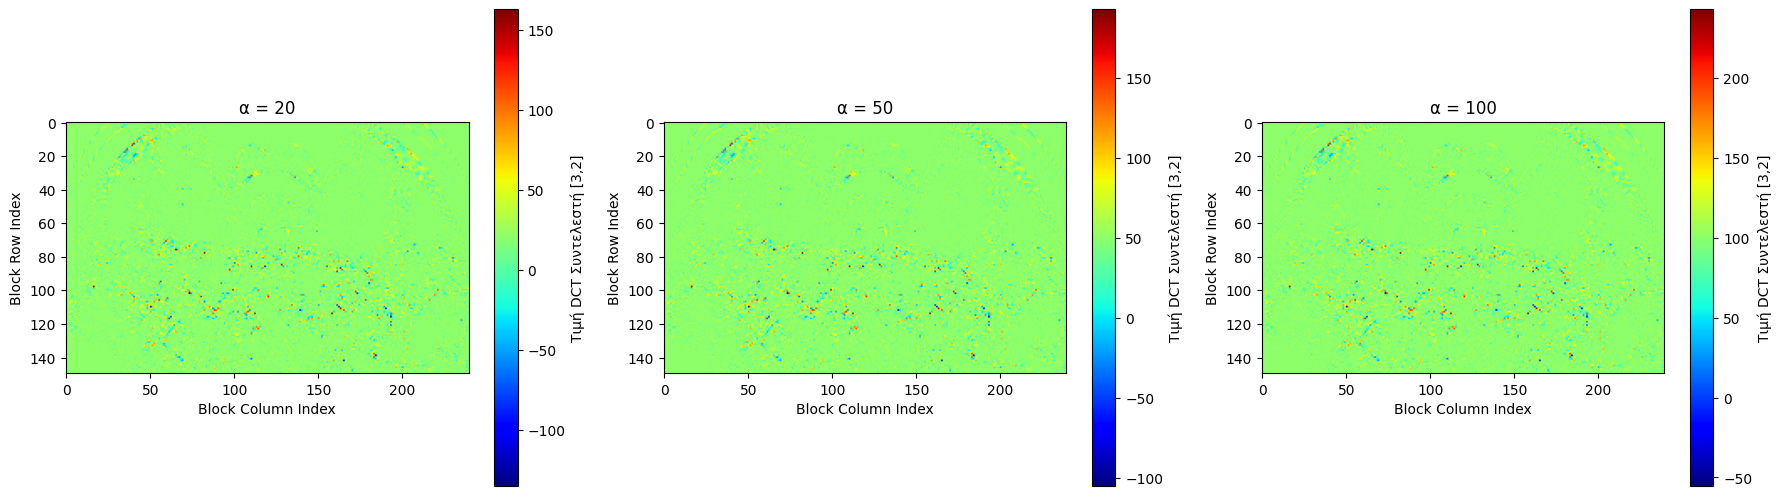

In [93]:
# Λίστα τιμών για το α
alpha_values = [20, 50, 100]

# Δημιουργία container για αποθήκευση heatmaps
heatmaps = []

for alpha in alpha_values:
    # Δημιουργία αντιγράφου εικόνας για το watermarking
    watermarked_image = np.zeros_like(image, dtype=np.float32)

    # Ενσωμάτωση watermark με δεδομένο alpha, για απλοποίηση χρησιμοποιούμε μια fixed τροποποίηση (π.χ. προσθήκη σε συγκεκριμένο συντελεστή)
    for i in range(blocks_h):
        for j in range(blocks_w):
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)
            dct_block = dct2(block)

            # Εδώ, για κάθε μπλοκ, προσθέτουμε είτε +alpha ή -alpha στο συντελεστή [3,2] ως παραδειγματική τροποποίηση
            # Για το παράδειγμα, ας υποθέσουμε ότι για κάθε block προσθέτουμε +alpha
            dct_block[3, 2] += alpha

            # Εφαρμογή IDCT
            idct_block = idct2(dct_block)
            watermarked_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = idct_block

    # Αποθήκευση ή απόκτηση heatmap για το συγκεκριμένο alpha:
    coeff_map = np.zeros((blocks_h, blocks_w))
    for i in range(blocks_h):
        for j in range(blocks_w):
            block = watermarked_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size].astype(np.float32)
            dct_block = dct2(block)
            coeff_map[i, j] = dct_block[3, 2]

    heatmaps.append(coeff_map)

    # Προαιρετική αποθήκευση της watermarked εικόνας:
    watermarked_image_clipped = np.clip(watermarked_image, 0, 255).astype(np.uint8)
    cv2.imwrite(f'watermarked_alpha_{alpha}.png', watermarked_image_clipped)

# Οπτικοποίηση των heatmaps για διάφορες τιμές του α
plt.figure(figsize=(18, 10))
for idx, alpha in enumerate(alpha_values):
    plt.subplot(2, 3, idx+1)
    plt.imshow(heatmaps[idx], cmap='jet')
    plt.colorbar(label='Τιμή DCT Συντελεστή [3,2]')
    plt.title(f'α = {alpha}')
    plt.xlabel('Block Column Index')
    plt.ylabel('Block Row Index')
plt.tight_layout()
plt.show()